In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 1 : Load the data
import os

data_dir = '/content/drive/MyDrive/plantvillage/PlantVillage'
print("Classes:", os.listdir(data_dir))

Classes: ['Tomato_Early_blight', 'Tomato__Tomato_mosaic_virus', 'Pepper__bell___Bacterial_spot', 'Tomato_Late_blight', 'Potato___Late_blight', 'Tomato__Target_Spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Potato___healthy', 'Tomato_Healthy', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [ ]:
import os
import random
from pathlib import Path
from PIL import Image
import shutil

In [ ]:
source_dir = '/content/drive/MyDrive/plantvillage/PlantVillage'
target_dir = '/content/drive/MyDrive/leaf_dataset_small'
classes = ['Tomato_Healthy', 'Tomato_Early_blight', 'Tomato_Late_blight']

In [ ]:
# Remove existing output folder if it exists
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)

In [ ]:
# Create output folder structure
for cls in classes:
    for split in ['train', 'val', 'test']:
        os.makedirs(f'{target_dir}/{split}/{cls}', exist_ok=True)

In [ ]:
# Step 2 : Preprocess and save resized images
def preprocess_images():
    for cls in classes:
        cls_source = os.path.join(source_dir, cls)
        image_paths = [p for p in Path(cls_source).iterdir() if p.suffix.lower() in ['.jpg', '.jpeg', '.png']]
        random.shuffle(image_paths)
        image_paths = image_paths[:200]

        for i, img_path in enumerate(image_paths):
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((128, 128))

                if i < 140:
                    split = 'train'
                elif i < 180:
                    split = 'val'
                else:
                    split = 'test'

                dest_path = f'{target_dir}/{split}/{cls}/{img_path.name}'
                img.save(dest_path)

            except Exception as e:
                print(f" Error with {img_path.name}: {e}")

In [ ]:
preprocess_images()
print("Images saved successfully!")

Images saved successfully!


In [ ]:
# Import Libraries and Load Dataset
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [ ]:
# Paths
base_path = '/content/drive/MyDrive/leaf_dataset_small'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [ ]:
# Load data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_ds = val_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_ds = test_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 805 images belonging to 3 classes.
Found 238 images belonging to 3 classes.
Found 119 images belonging to 3 classes.


In [ ]:
# Step 3 :CNN architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#  Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3802 - loss: 1.1321 - val_accuracy: 0.6639 - val_loss: 0.9994
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6204 - loss: 0.8851 - val_accuracy: 0.7269 - val_loss: 0.6210
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8145 - loss: 0.5142 - val_accuracy: 0.7647 - val_loss: 0.6108
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8383 - loss: 0.4260 - val_accuracy: 0.7941 - val_loss: 0.5736
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8815 - loss: 0.3298 - val_accuracy: 0.8403 - val_loss: 0.4294
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9252 - loss: 0.1900 - val_accuracy: 0.8193 - val_loss: 0.4510
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8924 - loss: 0.2573 - val_accuracy: 0.8487 - val_loss: 0.4737
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9394 - loss: 0.1619 - val_accuracy: 0.8571 - val_loss:

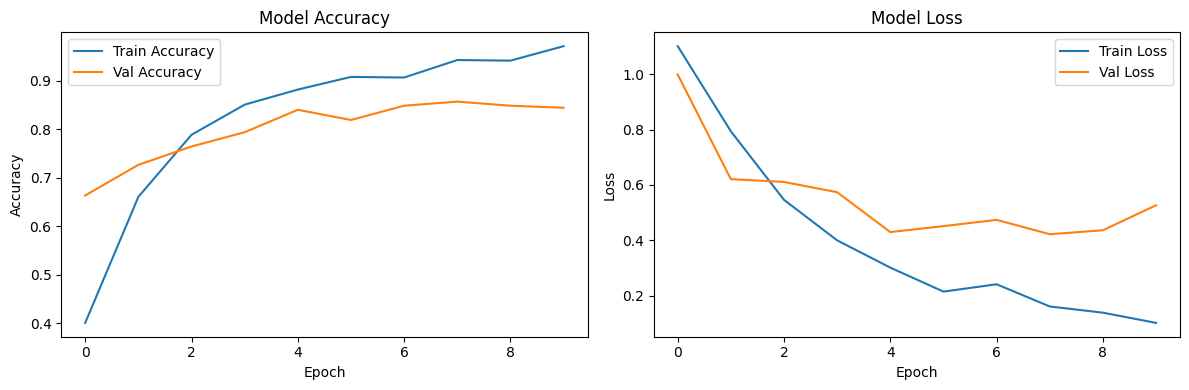

In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.8393 - loss: 0.5028
✅ Test Accuracy: 0.84


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


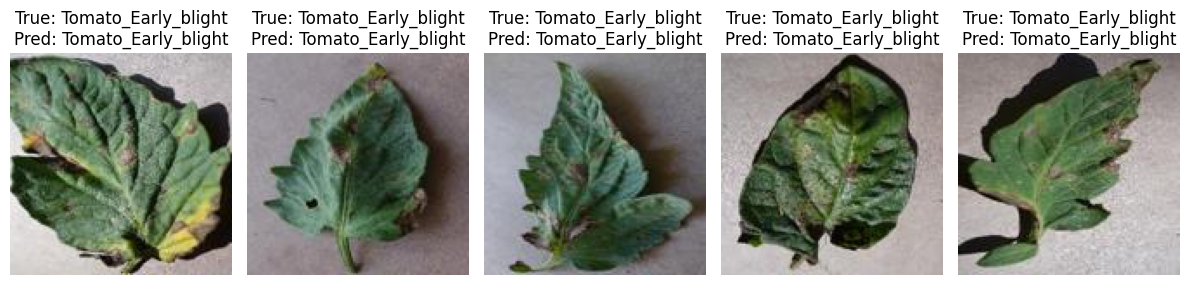

In [ ]:
# Sample Predication
import numpy as np

# Get class labels
class_names = list(test_ds.class_indices.keys())

# Get a batch of test images
images, labels = next(test_ds)
preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(labels, axis=1)

# Display 5 sample predictions
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}")
plt.tight_layout()
plt.show()